> This is part two ([part one](https://powershellone.wordpress.com/2021/03/03/graph-theory-with-powershell/)) of graph theory, focussing on "Small World Graphs", with PowerShell based on (Chapter 3) of the execellent book [Think Complexity 2e](https://greenteapress.com/wp/think-complexity-2e/) by Allen B. Downey (in fact Iâ€™d highly recommend any of the books in the â€œThinkâ€¦â€ series some of which I might cover in future posts). The book and the bookâ€™s source (in Python) are available for free through the bookâ€™s webpage (the physical book can be purchased too). 


# Table of contents
* ## [Some necessary theory](#theory)
* ## [Ring-Lattice graph](#ring)
* ## [Small-World graph Watts/Strogatz](#smallworld)
   * ### [Clustering Coefficient](#clustering)
   * ### [Shortest Path Length](#shortest)
   * ### [Small-World experiment (Watts, Strogatz)](#wse)

## Some necessary theory <a name="theory"></a>
Small World Graphs are graphs in which most nodes are not neighbors of one another, but the neighbors of any given node are likely to be neighbors of each other and most nodes can be reached from every other node by a small number of hops or steps. 

Most people have heard of Small World Graphs in conjunction with the [small-world expirement](https://en.wikipedia.org/wiki/Small-world_experiment) conducted by [Stanley Milgram](https://en.wikipedia.org/wiki/Stanley_Milgram) leading to the infamous phrase "six degress of separation". 

We will try to replicate the expirement based on [the work of Watts and Strogatz](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model). The Wattsâ€“Strogatz model is a random graph generation model (we talked about random graphs in [part one](https://powershellone.wordpress.com/2021/03/03/graph-theory-with-powershell/) of this seeries) that produces graphs with small-world properties, including short average path lengths and high clustering, which neither regular graphs (see below) nor random graphs exhibit at the same time.

- **Clustering** is a measure of the degree to which nodes in a graph tend to group together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit clusters characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes.

- **Average path length** - The average number of edges between two nodes.

- **Regular Graph** -  A graph where each node has the same number of neighbors the number of neighbors is also called the degree of the node.


The Watts and Strogatz model suggests the following steps to generate a Small World Graph:
- Start with a regular graph (a ring lattice graph can be used for this purpose) with n nodes and each node connected to k neighbors.
- Choose a subset of the edges and â€œrewireâ€ them by replacing them with random edges.

In a ring lattice graph the nodes are arranged in a circle with each node connected to the specified nearest neighbors.

## Ring-Lattice graph <a name="ring"></a>
Enough theory let's use some code. First we'll need some of the helper functions created in the [first part](https://powershellone.wordpress.com/2021/03/03/graph-theory-with-powershell/).

In [ ]:
Import-Module PSGraph

function Show-PSGraph ([ValidateSet('dot', 'circular', 'Hierarchical', 'Radial', 'fdp', 'neato', 'sfdp', 'SpringModelLarge', 'SpringModelSmall', 'SpringModelMedium', 'twopi')]~~LayoutEngine = 'circular') {
    ~~all = @(~~Input)
    ~~tempPath = [System.IO.Path]::GetTempFileName()
    ~~all | Out-File ~~tempPath
    ~~new = Get-Content ~~tempPath -raw | ForEach-Object { ~~_ -replace "`r", "" }
    ~~new | Set-Content -NoNewline ~~tempPath
    Export-PSGraph -Source ~~tempPath -ShowGraph -LayoutEngine ~~LayoutEngine
    Invoke-Item (~~tempPath + '.png')
    Remove-Item ~~tempPath
}

function New-Edge (~~From, ~~To, ~~Attributes, [switch]~~AsObject) {
    ~~null = ~~PSBoundParameters.Remove('AsObject')
    ~~ht = [Hashtable]~~PSBoundParameters
    if (~~AsObject) {
        return [PSCustomObject]~~ht
    }
    return ~~ht
}


function Get-Neighbours (~~Edges, ~~Name, [switch]~~Undirected) {
    ~~edgeObjects = @(~~Edges)
    if (@(~~Edges)[0].GetType().FullName -ne 'System.Management.Automation.PSCustomObject') {
        ~~edgeObjects = foreach (~~edge in ~~Edges) {
            [PSCustomObject]~~edge
        }
    }
    (& {
            (~~edgeObjects.where{ ~~_.From -eq ~~Name }).To
            if (~~Undirected) {
                (~~edgeObjects.where{ ~~_.To -eq ~~Name }).From
            }
        }).where{ ![String]::IsNullOrEmpty(~~_) }
}

function Get-LogSpace([Double]~~Minimum, [Double]~~Maximum, ~~Count) {
    ~~increment = (~~Maximum - ~~Minimum) / (~~Count - 1)
    for ( ~~i = 0; ~~i -lt ~~Count; ~~i++ ) {
        [Math]::Pow( 10, (~~Minimum + ~~increment * ~~i))
    }
}

We create a helper function to generate a Ring-Lattice graph. 

In [1]:
function Get-RingLattice(~~Nodes, ~~NumConnections){
    ~~ht = [ordered]@{}
    ~~ht.Nodes = ~~Nodes
    ~~cons = [int](~~NumConnections/2)
    ~~len = ~~Nodes.Count
    ~~ht.Edges = foreach (~~node in ~~Nodes){
        for (~~i=~~node+1;~~i -le (~~node+~~cons);~~i++){
            New-Edge ~~node ~~Nodes[(~~i % ~~len)] -AsObject
        }
    }
    ~~ht.Visual = graph {
        inline 'edge [arrowsize=0]'
        edge ~~ht.Edges -FromScript { ~~_.To } -ToScript { ~~_.From }
    }
    [PSCustomObject]~~ht
}

The below script needs to be able to find the current output cell; this is an easy method to get it.

Let's create a Ring-Lattice graph with 10 nodes and 4 connections per node.

In [ ]:
~~ringLattice = Get-RingLattice (0..9) 4
~~ringLattice.Visual | Show-PSGraph

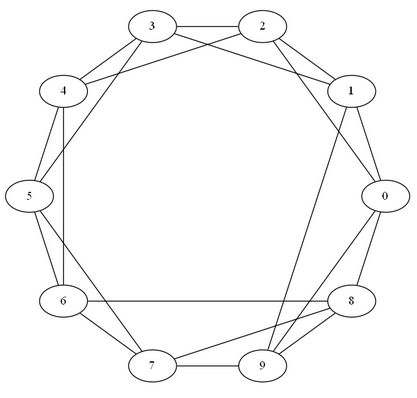

## Small-World Graphs (Watts-Strogatz) <a name="smallworld"></a>
To turn our Ring-Lattice graph into a small-world graph we need to "re-wire" the nodes. The algorithm for the re-wiring should follow this logic:
- Iterate over all edges and rewire them based on a specified probability.
- If and edge is chosen to be rewired
   - Leave the .From part of the edge as is.
   - Rewire the .To part of the edge to any random node, but...
      - The current .From and To. nodes
      - Any neighbours of the .From node
   - Replace the current edge with the old .From and the new .To pair
   

We can re-use of the Get-Neighbours function from my previous post.

In [1]:
function Get-SmallWorldGraph(~~Nodes, ~~NumConnections, ~~Probability){
    ~~graph = Get-RingLattice ~~Nodes ~~NumConnections
    ~~edges = ~~graph.Edges.Clone()
    foreach (~~edge in ~~graph.Edges){
        ~~rand = (Get-Random -Minimum 0 -Maximum 10000) / 10000
        if (~~rand -le ~~Probability) {
            ~~fromNeighbours = Get-Neighbours ~~graph.Edges ~~edge.From -Undirected
            #need to use foreach construct to expand nexted array of fromNeighbours
            ~~exclude = ~~edge.From,~~edge.To,(~~fromNeighbours.foreach{~~_})
            ~~toConnect = ~~graph.Nodes.where{~~_ -notin (~~exclude.foreach{~~_})}
            #remove the current edge
            #see https://en.wikipedia.org/wiki/De_Morgan%27s_laws
            ~~graph.Edges = ~~graph.Edges.where{~~_.From -ne ~~edge.From -or ~~_.To -ne ~~edge.To}
            #add the new edge += for "adding to an array is bad but good enough in this case
            ~~graph.Edges += New-Edge ~~edge.From (Get-Random -InputObject ~~toConnect) -AsObject
        }
    }
    #redo the visual part based on the new edges
    ~~graph.Visual = graph {
        inline 'edge [arrowsize=0]'
        edge ~~graph.Edges -FromScript { ~~_.To } -ToScript { ~~_.From }
    }
    ~~graph
}

The below script needs to be able to find the current output cell; this is an easy method to get it.

Below are three Small World graphs with the following properties:
- 20 nodes
- 4 connections per node
- Probabilities of 10%, 30%, and 80%

In [ ]:
foreach (~~prob in (.1,.2,.8)){
    ~~swGraph = Get-SmallWorldGraph (0..19) 4 ~~prob
    ~~swGraph.Visual | Show-PSGraph
}

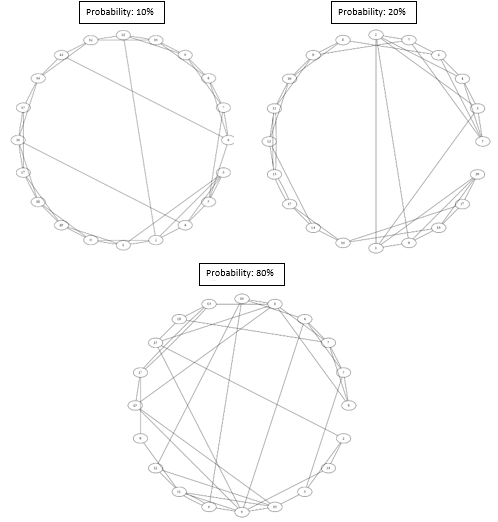

As a next step we need to develop methods that helps us to evaluate the clustering and path-length properties of the produced graphs.

### Clustering Coefficient <a name="clustering"></a>
A cluster can be defined as a set of nodes with edges between all pairs of nodes in the set. The clustering coefficient for a node is given by the proportion of actual links between the nodes within its neighbourhood divided by the number of links that could possibly exist between them. If we iterate over every node of a graph and calculate this proportion and take the average of those, we are getting the `clusteirng coefficient` for the graph.
The number of unique connections between a set of n nodes can be calculated with the formula ~~\frac{n(n-1)}{2}~~.
If you imagine a room with n people, where you want to determine the number of unique pairs:
- The first person can pair up with everyone except themselves n-1..
- ...so can everyone else n*(n-1). 
- Since n represents the number of people rather than pairs the result needs to be divided by 2 ~~\frac{n(n-1)}{2}~~.

Below is the implementation of the clustering coefficient algorithm.

In [1]:
function Get-ClusteringCoefficient (~~Graph){
    ~~individualCEs = foreach (~~node in ~~Graph.Nodes){
        ~~neighbours = Get-Neighbours ~~Graph.Edges ~~node -Undirected
        ~~numNeighbours = ~~neighbours.Count
        #CE undefined skip to next node
        if (~~numNeighbours -lt 2) { 
            [Single]::NaN 
            continue
        }
        ~~possibleConnections = ~~numNeighbours * (~~numNeighbours -1) / 2
        ~~nodes = ~~Graph.Nodes
        ~~actualConnections = for (~~i = 0; ~~i -lt ~~numNeighBours; ~~i++) {
            for (~~j = 0; ~~j -lt ~~neighbours.Count; ~~j++) {
                if (~~i -lt ~~j) {
                    ~~l = ~~neighbours[~~i]
                    ~~r = ~~neighbours[~~j]
                    #the way the edge objects are setup currently we will need to check for both sides
                    #would be better to setup sundirected edges differently
                    ~~Graph.Edges.where{(~~_.From -eq ~~l -and ~~_.To -eq ~~r) -or (~~_.From -eq ~~r -and ~~_.To -eq ~~l) }   
                }
            }
        }
        (~~actualConnections.Count/~~possibleConnections)
    }
    #return the average of the clustering coefficients per node exlcuding NaNs
    ~~individualCEs.where{-not ([Single]::IsNaN(~~_)) }
}

The below script needs to be able to find the current output cell; this is an easy method to get it.

If we test with our Ring-Lattice graph from our, we can get the expected .5 (each nodes has 4 neighbours with 3 connections out of possible 6 connections)

In [2]:
Get-ClusteringCoefficient ~~ringLattice

0.5


### Shortest Path Length <a name="shortest"></a>

The next step is to calculate the shortest path length, which is the average length of the shortest path between each pair of nodes. 

There are several well-known algorithms to do this one of them is the [Bellmann-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm). Fortunately, PowerShell MVP [Doug Finke](https://twitter.com/dfinke?lang=en) was already kind enough to implement the algorithm in PowerShell (see [here](https://github.com/dfinke/powershell-algorithms/tree/master/src/algorithms/graph/bellman-ford). Below is my version based on Doug's implementation.

At a high level, the algorithm works like this:
- Based on a graph object and a given starting node:
- For each node in the graph iterate over each of the node's neighbours.
- Keep track of the distances by just adding 1 for the respective pair.
- Add the path length to the pair in case it's shorter than the current distance saved for the pair.

In [ ]:
function Get-ShortestPath(~~Graph, ~~StartNode) {
    ~~distances = @{}
    
    # Init all distances with infinity assuming that currently we can't reach
    # any of the nodes except start one.
    ~~distances[~~startNode] = 0
    foreach (~~node in ~~Graph.Nodes) {
        if (~~node -ne ~~StartNode) {
            ~~distances[~~node] = [double]::PositiveInfinity
        }
    }
    for (~~i= 0; ~~i -lt (~~Graph.Nodes.count - 1); ~~i++){
        # During each iteration go through all nodes
        ~~nodes = ~~distances.Clone().Keys
        foreach (~~node in ~~nodes) {
            ~~neighbours = Get-Neighbours ~~Graph.Edges ~~node -Undirected
            foreach (~~neighbour in ~~neighbours) {
                # Find out if the distance to the neighbour is shorter in this iteration
                # than in previous one.
                ~~distanceToNode = ~~distances[~~node]
                ~~distanceToNeighbour = ~~distanceToNode + 1
                if (~~distanceToNeighbour -lt ~~distances[~~neighbour]) {
                    ~~distances[~~neighbour] = ~~distanceToNeighbour
                }
            }
        }
    }

    ~~distances.GetEnumerator().foreach{
        [PSCustomObject][ordered]@{
            Source      = ~~startNode
            Destination = ~~_.Name
            Distance    = ~~_.Value
        }
    }
}

The function returns an object array with Source, Distance, and Destination properties. If we use it on the first node of a our previously created Ring-Lattice graph (added here again for convenience), we get the following result:

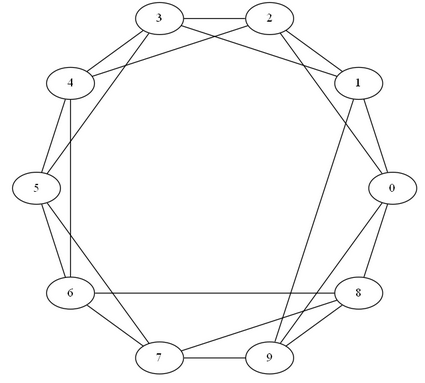

In [1]:
Get-ShortestPath ~~ringLattice 0

The below script needs to be able to find the current output cell; this is an easy method to get it.


Source Destination Distance
------ ----------- --------
0      9           1
0      8           1
0      7           2
0      6           2
0      5           3
0      4           2
0      3           2
0      2           1
0      1           1
0      0           0



To get the average shortest path length for a whole graph we need to ... :
- ... do this for every unique starting point (From) in the graph.
- Remove the infinity (for pairs that don't have a connection) and 0 (from node to self) Distance entries.
- Get the average of the remaining distances.

In [3]:
~~groupedEdges = ~~ringLattice.Edges | group From
~~distances = foreach (~~group in ~~groupedEdges){
    Get-ShortestPath ~~ringLattice ~~group.Name
}
(~~distances.where{~~_.Distance -ne 0 -and ~~_.Distance -ne [double]::PositiveInfinity} |
    Measure-Object -Property Distance -Average).Average

1.66666666666667


### Small-World experiment (Watts, Strogatz) <a name="wse"></a>
Great, now we have everything in place to do duplicate the Small-world expirement. Showing that there are Small-Word graphs with a certain range of probability (for re-wiring) with high clustering-coefficients (like regular graphs) and a short average path lengths (like in random graphs).

In practice it turned out that, at least with the haphazardly version of my code, the PowerShell functions are not executing nearly fast enough to carry out the experiment with 1000 nodes for each graph and 10 connections each. Even though I have added multi-threading to the Shortest-Path parts using [PSThreadJobs's](https://www.powershellgallery.com/packages/ThreadJob/2.0.3) `Start-ThreadJob` function, since this is definitely the bottleneck.

In [ ]:
function Do-Experiment (~~Nodes = (0..20), ~~NumConnections=3, ~~Probabilities){
    foreach (~~probability in ~~Probabilities){
        ~~apl = [System.Collections.ArrayList]@()
        ~~ccoe = [System.Collections.ArrayList]@()
        ~~jobs = @()
        ~~graph = Get-SmallWorldGraph ~~Nodes ~~NumConnections ~~probability
        ~~groupedEdges = ~~graph.Edges | group From
        foreach (~~group in ~~groupedEdges){
            ~~initBlock = [ScriptBlock]::Create(
            'function Get-ShortestPath{' + (Get-Command Get-ShortestPath).Definition + '}' +
            'function Get-Neighbours{' + (Get-Command Get-Neighbours).Definition + '}'
            )
            ~~jobs += Start-ThreadJob -InitializationScript ~~initBlock {
                ~~group = ~~using:group
                Get-ShortestPath ~~using:graph ~~group.Name
            }
        }
        ~~null = ~~jobs | Wait-Job
        ~~distances = ~~jobs | Receive-Job
        ~~null = ~~jobs | Remove-Job
        ~~null = ~~apl.Add((~~distances.where{~~_.Distance -ne 0 -and ~~_.Distance -ne [double]::PositiveInfinity} |
            Measure-Object -Property Distance -Average).Average)
        ~~null = ~~ccoe.Add((Get-ClusteringCoefficient ~~graph))
        
        [PSCustomObject][ordered]@{
            Probability = ~~probability
            AveragePathLength = (~~apl | Measure-Object -Average).Average
            ClusteringCoeeficient = (~~ccoe | Measure-Object -Average).Average
        }
    }
}

~~probabilities = Get-LogSpace -4 0 9
~~result = Do-Experiment -Probabilities ~~probabilities

While this is unfortunate, I have definitely learned a lot along the way. We can take the results from the original Watts/Strogatz paper (L = average path length standardized, C = clustering coefficients standardizes) instead and appreciate that as the probability increases, the average path length decreases quite rapidly, because even a small number of randomly rewired edges provide shorter paths between nodes that are far apart. Replacing neighbouring links decreases the clustering coeï¬ƒcient much more slowly.
As a result, there is a wide range of probabilities with high clustering coeffeicients and low average path lengths.

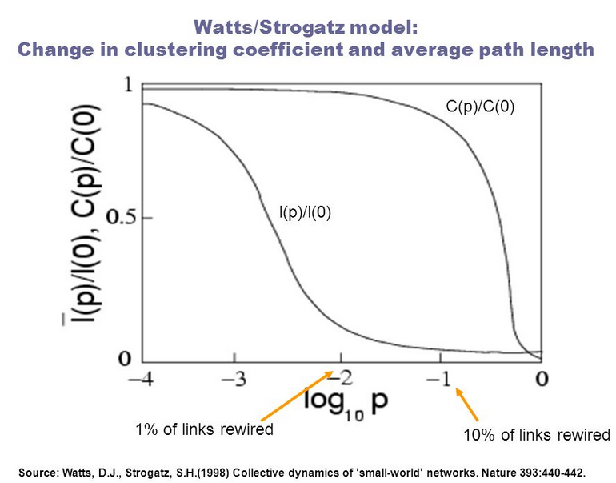